# 3. Sample forecasting with XGBoost

The following notebook shows sample forecasting done with XGBoost. Primary features used are historical traffic volume information aggregated per station per state (disregards separation between lanes and direction of travel). The window size used for the input is a weeks worth of traffic data (24*7) and forecasts T+1 to T+24 for a given day for the hourly entries.

In [1]:
# !pip install gdown numpy pandas sklearn matplotlib lightgbm reverse_geocoder folium selenium flaml pystan==2.19.1.1

In [2]:
# !pip install prophet

In [3]:
import datetime as dt
import array

import gdown
import reverse_geocoder
from tqdm.notebook import tqdm
import os
import pylab
import pandas as pd
import numpy as np
from IPython.display import display
import ipywidgets as widgets
import pickle
import math

import warnings
warnings.filterwarnings('ignore')

# Modify to adjust figure sizes
pylab.rcParams['figure.figsize'] = (12, 4)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
os.chdir('..')

In [6]:
from utils import preprocess, datautils
from utils.config import filenames

import importlib
importlib.reload(preprocess)
importlib.reload(datautils)

<module 'utils.datautils' from 'C:\\Users\\combi\\Documents\\gitrepos\\us-traffic\\src\\utils\\datautils.py'>

In [7]:
DATA_LOCATION = os.path.join(os.getcwd(), 'data')
processed_dir = os.path.join(DATA_LOCATION, "processed")

In [8]:
datautils.create_folder(DATA_LOCATION)
datautils.create_folder(processed_dir)

Folder 'C:\Users\combi\Documents\gitrepos\us-traffic\src\data' exists.
Folder 'C:\Users\combi\Documents\gitrepos\us-traffic\src\data\processed' exists.


In [9]:
traffic_data, traffic_stations = datautils.load_traffic_datasets(
                                                DATA_LOCATION,
                                                filenames["TRAFFIC_DATA"],
                                                filenames["TRAFFIC_STATIONS"])

Loading traffic data from 'dot_traffic_2015.txt.gz' ...
Loading traffic stations from 'dot_traffic_stations_2015.txt.gz' ...
Finished loading data.


In [10]:
fips_df, fips_loc_df = datautils.load_other_datasets(DATA_LOCATION,
                                                    filenames["FIPS_CODE"],
                                                    filenames["FIPS_LOC"])
fips_state_ref = datautils.create_fips_ref(fips_df)

Loading FIPS state codes reference from 'fips_code.csv' ...
Loading approximate FIPS coordinates reference from 'fips_latlong.csv' ...
Finished loading data.


Modify the cell below as needed

In [11]:
fips_state_code = 6

In [12]:
model_input_dir = os.path.join(processed_dir, str(fips_state_code))
datautils.create_folder(model_input_dir)

station_ids = [x.split('.')[0] for x in os.listdir(model_input_dir)]

Folder 'C:\Users\combi\Documents\gitrepos\us-traffic\src\data\processed\6' exists.


Vectorization is applied for speedups in retrieving sliding windows. To accomodate for the given task, the code was modified [from here](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5) to get the proper dimensions for input and output values.

In [13]:
def get_sliding_windows(array, max_time, sub_window_size,
                         stride_size):
    sub_windows = (
        np.expand_dims(np.arange(sub_window_size), 0) +
        np.expand_dims(np.arange(max_time + 1, step=stride_size), 0).T
    )
    array = array[sub_windows]
    X_values = array[:-1, :]
    y_values = array[1:, -stride_size:]

    return X_values, y_values

Modify this cell depending on the nature of the data to be forecasted. In this case, the window size retrieves hourly entries for seven days prior to the date to be forecasted. Since the output window size is 24, a day's worth of traffic volume is to be determined by the model.

In [14]:
input_window_size = 24*7
output_window_size = 24
verbose = False

In [15]:
X_train = np.empty((0, input_window_size))
y_train = np.empty((0, output_window_size))

X_test = np.empty((0, input_window_size))
y_test = np.empty((0, output_window_size))

for station_id in tqdm(station_ids):
    processed_df = preprocess.get_transformed_vol_df(station_id,
                                                     save_dir=model_input_dir,
                                                     verbose=verbose)
    train_df, _, test_df = preprocess.get_dataset_splits(processed_df)

    try:
        arr = train_df["traffic_volume"].to_numpy()
        sub_X_train, sub_y_train = get_sliding_windows(array=arr,
                                                     max_time=arr.shape[0]-input_window_size,
                                                     sub_window_size=input_window_size,
                                                     stride_size=output_window_size)

        X_train = np.append(X_train, sub_X_train, axis=0)
        y_train = np.append(y_train, sub_y_train, axis=0)

        arr = test_df["traffic_volume"].to_numpy()
        sub_X_test, sub_y_test = get_sliding_windows(array=arr,
                                 max_time=arr.shape[0]-input_window_size,
                                 sub_window_size=input_window_size,
                                 stride_size=output_window_size)

        X_test = np.append(X_test, sub_X_test, axis=0)
        y_test = np.append(y_test, sub_y_test, axis=0)

    except:
        print("Unable to retrieve complete windowed sequences.")

In [16]:
from sklearn.metrics import mean_squared_error

Folder 'C:\Users\combi\Documents\gitrepos\us-traffic\src\models' exists.


Folder 'C:\Users\combi\Documents\gitrepos\us-traffic\src\data\processed\12' exists.



Loaded trained model


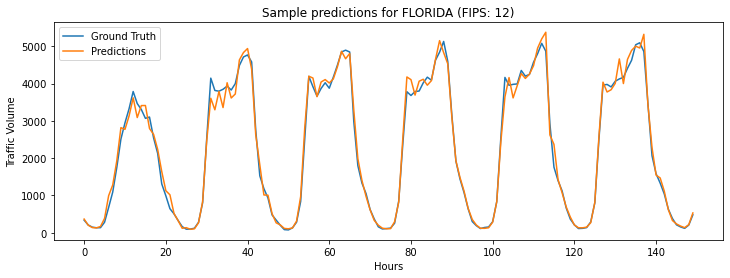

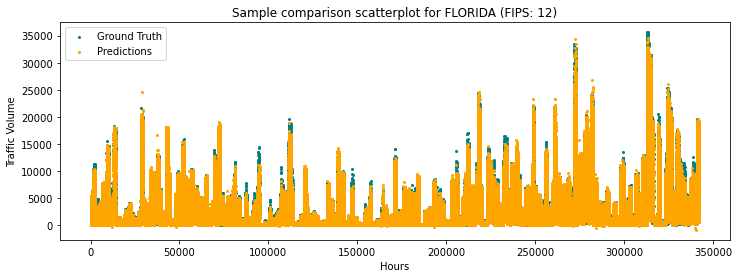

Folder 'C:\Users\combi\Documents\gitrepos\us-traffic\src\data\processed\51' exists.



Loaded trained model


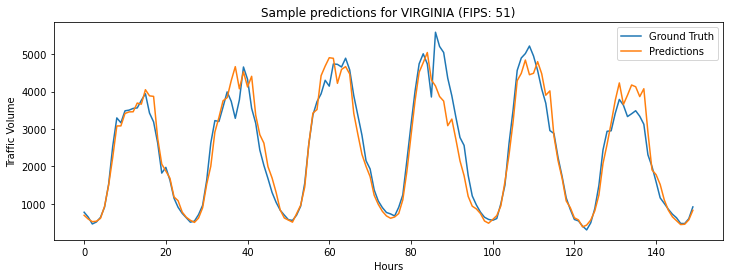

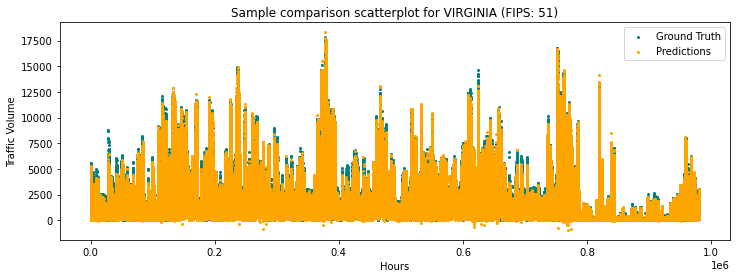

Folder 'C:\Users\combi\Documents\gitrepos\us-traffic\src\data\processed\39' exists.



Loaded trained model


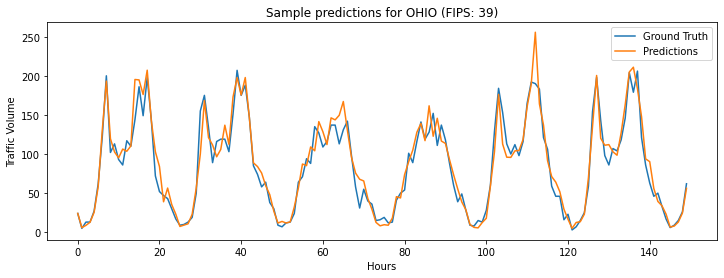

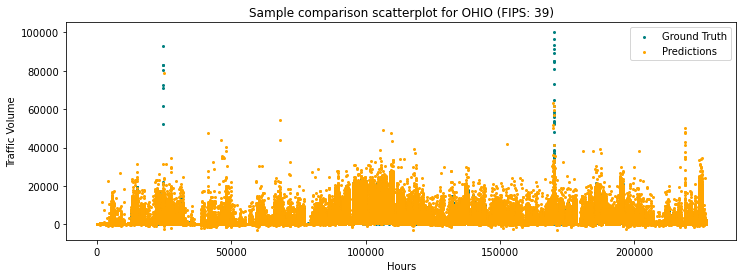

Folder 'C:\Users\combi\Documents\gitrepos\us-traffic\src\data\processed\13' exists.



Loaded trained model


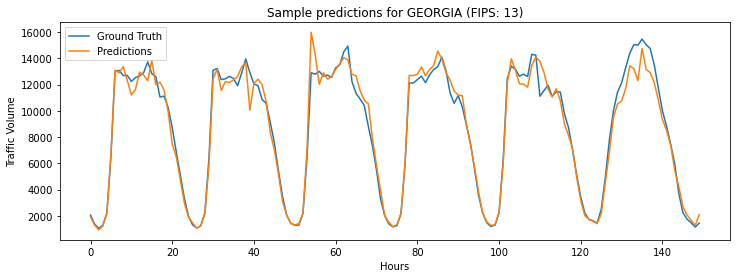

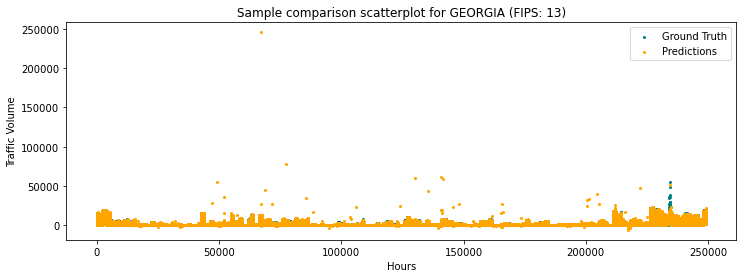

Folder 'C:\Users\combi\Documents\gitrepos\us-traffic\src\data\processed\55' exists.



Loaded trained model


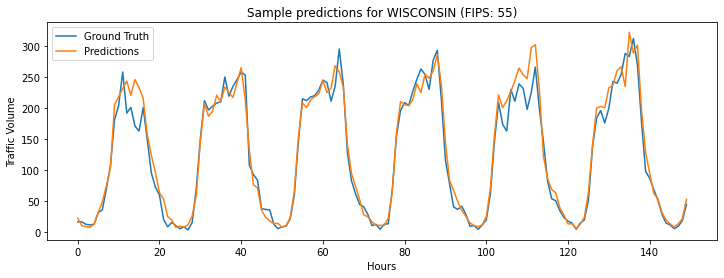

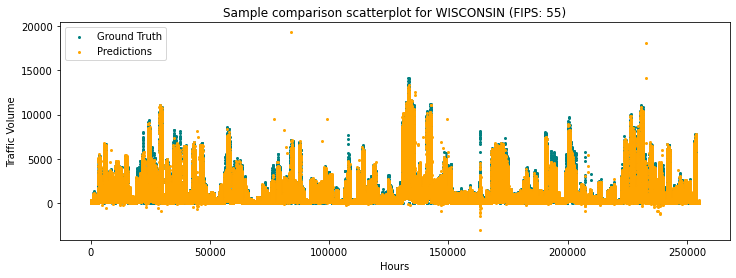

Folder 'C:\Users\combi\Documents\gitrepos\us-traffic\src\data\processed\53' exists.



Loaded trained model


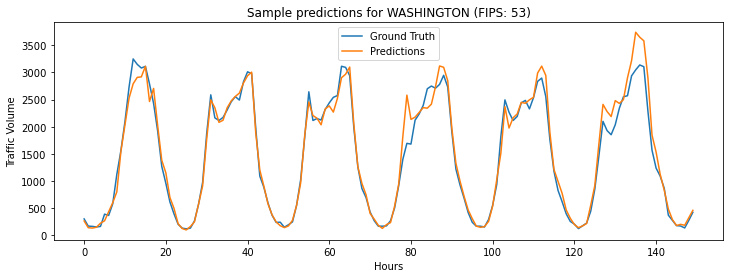

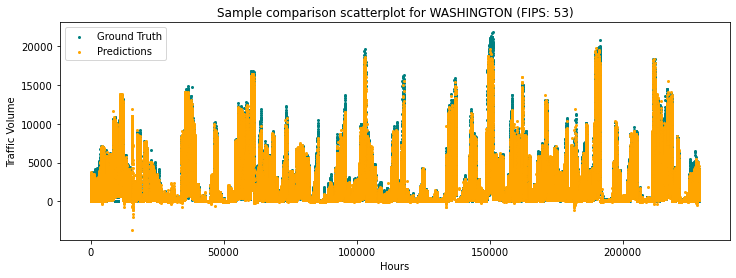

Folder 'C:\Users\combi\Documents\gitrepos\us-traffic\src\data\processed\16' exists.



Loaded trained model


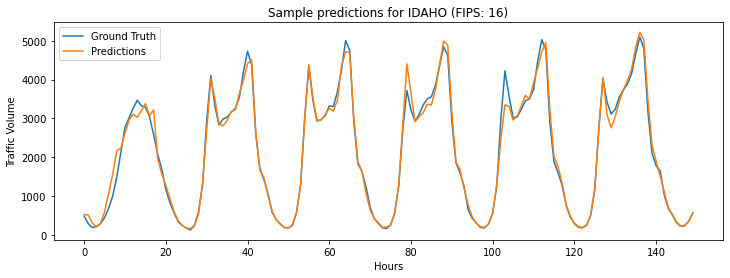

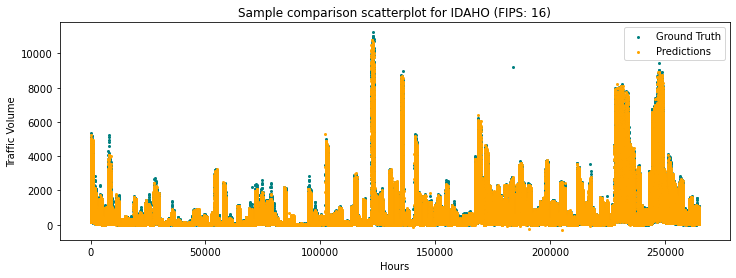

Folder 'C:\Users\combi\Documents\gitrepos\us-traffic\src\data\processed\36' exists.



Loaded trained model


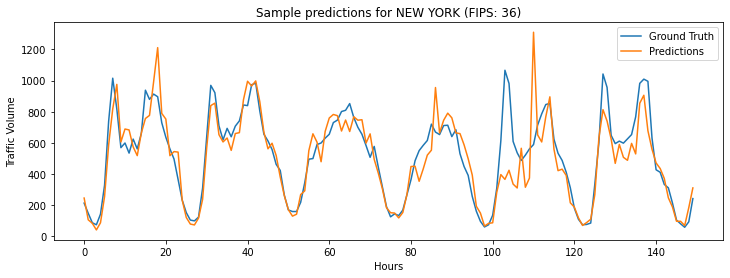

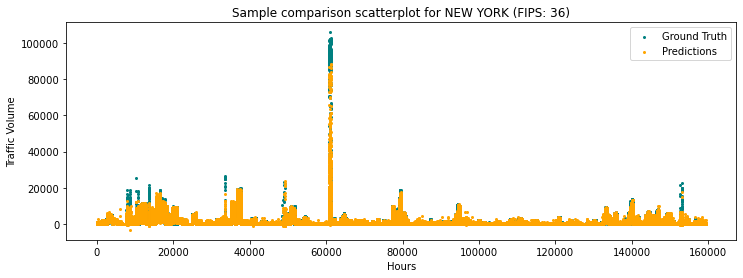

Folder 'C:\Users\combi\Documents\gitrepos\us-traffic\src\data\processed\40' exists.



Loaded trained model


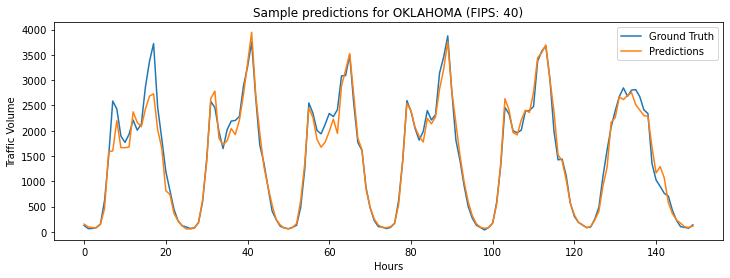

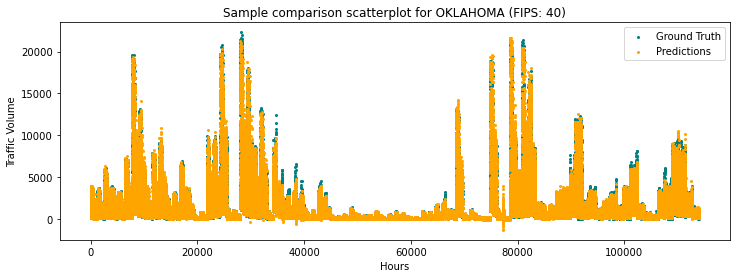

Folder 'C:\Users\combi\Documents\gitrepos\us-traffic\src\data\processed\28' exists.



Loaded trained model


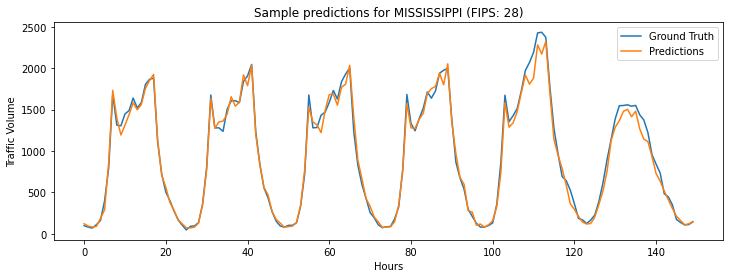

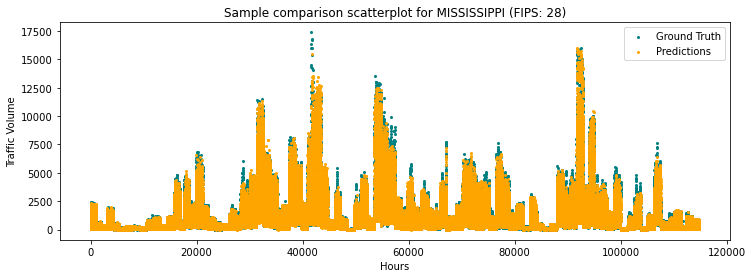

Folder 'C:\Users\combi\Documents\gitrepos\us-traffic\src\data\processed\29' exists.



Loaded trained model


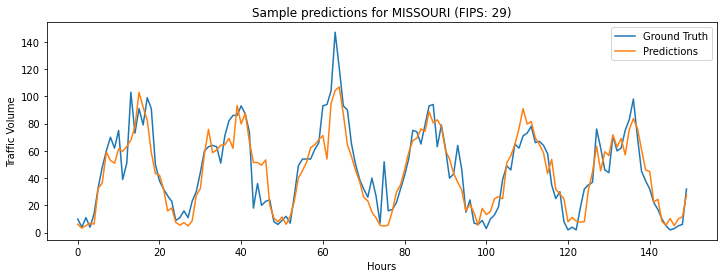

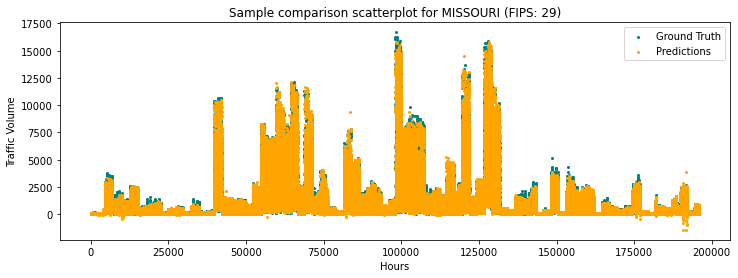

In [17]:
MODEL_LOCATION = os.path.join(os.getcwd(), 'models')
datautils.create_folder(MODEL_LOCATION)

codes = traffic_data["fips_state_code"].value_counts()[0:11].index
verbose = False
results = []
for fips_state_code in tqdm(codes):
    model_input_dir = os.path.join(processed_dir, str(fips_state_code))
    datautils.create_folder(model_input_dir)

    station_ids = [x.split('.')[0] for x in os.listdir(model_input_dir)]

    X_train = np.empty((0, input_window_size))
    y_train = np.empty((0, output_window_size))

    X_test = np.empty((0, input_window_size))
    y_test = np.empty((0, output_window_size))

    for station_id in tqdm(station_ids):
        processed_df = preprocess.get_transformed_vol_df(station_id,
                                                         save_dir=model_input_dir,
                                                         verbose=verbose)
        train_df, _, test_df = preprocess.get_dataset_splits(processed_df)

        try:
            arr = train_df["traffic_volume"].to_numpy()
            sub_X_train, sub_y_train = get_sliding_windows(array=arr,
                                                         max_time=arr.shape[0]-input_window_size,
                                                         sub_window_size=input_window_size,
                                                         stride_size=output_window_size)

            X_train = np.append(X_train, sub_X_train, axis=0)
            y_train = np.append(y_train, sub_y_train, axis=0)

            arr = test_df["traffic_volume"].to_numpy()
            sub_X_test, sub_y_test = get_sliding_windows(array=arr,
                                     max_time=arr.shape[0]-input_window_size,
                                     sub_window_size=input_window_size,
                                     stride_size=output_window_size)

            X_test = np.append(X_test, sub_X_test, axis=0)
            y_test = np.append(y_test, sub_y_test, axis=0)

        except:
            print("Unable to retrieve complete windowed sequences.")

    file_path = os.path.join(MODEL_LOCATION, f"xgb-{fips_state_code}-allstations.pkl")

    try:
        with open(file_path, "rb") as f:
            model = pickle.load(f)
        print("Loaded trained model")

    except:
        model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror',
                                                                 n_estimators=1000))

        model.fit(X_train, y_train)

        with open(file_path, "wb") as f:
            pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    y_pred = model.predict(X_test) 
    yt = y_test.flatten()
    yp = y_pred.flatten()
    rmse = mean_squared_error(yt, yp, squared=False)
    
    results.append([rmse, yt.max(), yt.mean(), yt.std()])
    
    # Plot sample results
    limit = 150

    x = range(0, limit)
    plt.plot(x, yt[0:limit], label="Ground Truth")
    plt.plot(x, yp[0:limit], label="Predictions")
    plt.legend()
    plt.ylabel("Traffic Volume")
    plt.xlabel("Hours")
    plt.title(f"Sample predictions for {fips_state_ref[fips_state_code].upper()} (FIPS: {fips_state_code})")
    plt.show()

    limit = len(yt)

    x = range(0, limit)
    plt.scatter(x, yt[0:limit], 
                s=4, color="teal", label="Ground Truth")
    plt.scatter(x, yp[0:limit], 
                s=4, color="orange", label="Predictions")
    plt.legend()
    plt.ylabel("Traffic Volume")
    plt.xlabel("Hours")
    plt.title(f"Sample comparison scatterplot for {fips_state_ref[fips_state_code].upper()} (FIPS: {fips_state_code})")
    plt.show()

In [18]:
results_df = pd.DataFrame(results, columns =['RMSE (Test)', 'Max Traffic Volume (Test)',
                                             'Mean Traffic Volume (Test)', 
                                             'Traffic Volume Standard Deviation(Test)'])

In [19]:
results_df["FIPS State Code"] = codes
results_df["State Name"] = [fips_state_ref[fips].upper() for fips in codes]

In [20]:
results_df

,RMSE (Test),Max Traffic Volume (Test),Mean Traffic Volume (Test),Traffic Volume Standard Deviation(Test),FIPS State Code,State Name
0,814.343292,35606.0,2589.144178,3651.882857,12,FLORIDA
1,399.729373,17801.0,1459.280962,1785.368333,51,VIRGINIA
2,1807.944088,100095.0,2827.452846,3734.130332,39,OHIO
3,850.074584,55398.0,1958.167863,3135.525856,13,GEORGIA
4,370.427766,14132.0,1131.936928,1563.803980,55,WISCONSIN
5,783.391322,21754.0,2146.187504,2997.321082,53,WASHINGTON
6,215.129808,11241.0,622.384583,1074.048508,16,IDAHO
7,2490.213012,105893.0,1371.468579,4295.141007,36,NEW YORK
8,623.811068,22308.0,1555.004114,2568.417780,40,OKLAHOMA
9,464.095366,17396.0,1324.281701,1820.947934,28,MISSISSIPPI


Considering the range of the traffic volume, lack of parameter modifications, and output window size, these results could serve as a decent baseline for forecasting traffic predictions.